# Importing libraries and dataset

In [14]:

%matplotlib inline
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets

print(torch.__version__)

1.5.0


In [15]:
download = datasets.MNIST("./MNIST/", train=True, download=True)

In [16]:
Datapath = "MNIST/MNIST/raw/"

# Defining basic functions needed

In [17]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [18]:
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

In [19]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [20]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [21]:
TrainImages = read_image_file(os.path.join(Datapath, 'train-images-idx3-ubyte'))
TrainLabels = read_label_file(os.path.join(Datapath, 'train-labels-idx1-ubyte'))
TestImages = read_image_file(os.path.join(Datapath, 't10k-images-idx3-ubyte'))
TestLabels = read_label_file(os.path.join(Datapath, 't10k-labels-idx1-ubyte'))

In [26]:
print("Train images size : " + str(TrainImages.size()))
print("Train labels size : " + str(TrainImages.size()))
print("Test images size  : " + str(TrainImages.size()))
print("Test labels size  : " + str(TrainImages.size()))

Train images size : torch.Size([60000, 784])
Train labels size : torch.Size([60000, 784])
Test images size  : torch.Size([60000, 784])
Test labels size  : torch.Size([60000, 784])


In [27]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available!")
    device = "cuda"
else:
    print("GPU is not available")
    device = "cpu"

GPU is available!


# Defining the autoencoder

In [28]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 100), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(100, 28*28), nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [29]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1.5, momentum=0.5)

In [30]:
iterations = 100
BatchSize = 10000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages, 0, torch.linspace(i*BatchSize, (i+1)*BatchSize-1, steps=BatchSize).long()).double()
        inputs = inputs/255
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    print(" Iteratioin %3d/%3d, loss was %2.3f"%(epoch+1, iterations, runningLoss/(epoch+1)))
print("Finished training")

 Iteratioin   1/150, loss was 0.615
 Iteratioin   2/150, loss was 0.280
 Iteratioin   3/150, loss was 0.167
 Iteratioin   4/150, loss was 0.114
 Iteratioin   5/150, loss was 0.088
 Iteratioin   6/150, loss was 0.071
 Iteratioin   7/150, loss was 0.060
 Iteratioin   8/150, loss was 0.052
 Iteratioin   9/150, loss was 0.046
 Iteratioin  10/150, loss was 0.041
 Iteratioin  11/150, loss was 0.036
 Iteratioin  12/150, loss was 0.033
 Iteratioin  13/150, loss was 0.030
 Iteratioin  14/150, loss was 0.027
 Iteratioin  15/150, loss was 0.025
 Iteratioin  16/150, loss was 0.023
 Iteratioin  17/150, loss was 0.021
 Iteratioin  18/150, loss was 0.020
 Iteratioin  19/150, loss was 0.018
 Iteratioin  20/150, loss was 0.017
 Iteratioin  21/150, loss was 0.016
 Iteratioin  22/150, loss was 0.015
 Iteratioin  23/150, loss was 0.014
 Iteratioin  24/150, loss was 0.013
 Iteratioin  25/150, loss was 0.013
 Iteratioin  26/150, loss was 0.012
 Iteratioin  27/150, loss was 0.011
 Iteratioin  28/150, loss wa

KeyboardInterrupt: 

&lt;matplotlib.image.AxesImage at 0x7f447b3fab10&gt;

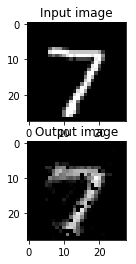

In [32]:
test_img = TestImages[0]

output_img = net((test_img.double().to(device))/255).data
output_img = (output_img*255).byte()
output_img = output_img.view(-1, 28, 28)

if device == "cuda":
    output_img = output_img.cpu()

test_img = test_img.view(-1, 28, 28)

plt.subplot(2,1,1)
img = np.array(test_img.numpy())[0]
plt.title("Input image")
plt.imshow(img, cmap="gray")

plt.subplot(2,1,2)
out_img = np.array(output_img.numpy())[0]
plt.title("Output image")
plt.imshow(out_img, cmap="gray")

In [34]:
help(torch.Tensor.view)

Help on method_descriptor:

view(...)
    view(*shape) -&gt; Tensor
    
    Returns a new tensor with the same data as the :attr:`self` tensor but of a
    different :attr:`shape`.
    
    The returned tensor shares the same data and must have the same number
    of elements, but may have a different size. For a tensor to be viewed, the new
    view size must be compatible with its original size and stride, i.e., each new
    view dimension must either be a subspace of an original dimension, or only span
    across original dimensions :math:`d, d+1, \dots, d+k` that satisfy the following
    contiguity-like condition that :math:`\forall i = 0, \dots, k-1`,
    
    .. math::
    
      \text{stride}[i] = \text{stride}[i+1] \times \text{size}[i+1]
    
    Otherwise, :meth:`contiguous` needs to be called before the tensor can be
    viewed. See also: :meth:`reshape`, which returns a view if the shapes are
    compatible, and copies (equivalent to calling :meth:`contiguous`) otherwise.